In [5]:
import numpy as np
import argparse
import time
import cv2
import os
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [6]:
def plotting(image):
	plt.figure(figsize=(13,13))
	plt.imshow(image)
	plt.axis('off')
	plt.show()

In [9]:
# load the COCO class labels our YOLO model was trained on
labelsPath = os.path.sep.join(["coco.names"])
LABELS = open(labelsPath).read().strip().split("\n")
# initialize a list of colors to represent each possible class label
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),
	dtype="uint8")

# derive the paths to the YOLO weights and model configuration
weightsPath = os.path.sep.join(["yolov3.weights"])
configPath = os.path.sep.join(["yolov3.cfg"])
# load our YOLO object detector trained on COCO dataset (80 classes)
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

[INFO] loading YOLO from disk...


In [10]:
test1 = 'test1.jpg'
test4 = 'test4.jpg'

In [15]:
def process(image, stage1=False, stage2=False):
  super1 = np.copy(image)
  super2 = np.copy(image)
  (H, W) = image.shape[:2]
	# determine only the *output* layer names that we need from YOLO
  ln = net.getLayerNames()
  ln = [ln[i- 1] for i in net.getUnconnectedOutLayers()]
	# construct a blob from the input image and then perform a forward
	# pass of the YOLO object detector, giving us our bounding boxes and
	# associated probabilities
  blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416),
		swapRB=True, crop=False)
  net.setInput(blob)
  start = time.time()
  layerOutputs = net.forward(ln)
  end = time.time()
	# show timing information on YOLO
  print("[INFO] YOLO took {:.6f} seconds".format(end - start))

	# initialize our lists of detected bounding boxes, confidences, and
	# class IDs, respectively
  boxes = []
  confidences = []
  classIDs = []

	# loop over each of the layer outputs
  for output in layerOutputs:
		# loop over each of the detections
	  for detection in output:
			# extract the class ID and confidence (i.e., probability) of
			# the current object detection
		  scores = detection[5:]
		  classID = np.argmax(scores)
		  confidence = scores[classID]
			# filter out weak predictions by ensuring the detected
			# probability is greater than the minimum probability
		  if classID != 2:
			  continue
		  if confidence > 0.5:
				# scale the bounding box coordinates back relative to the
				# size of the image, keeping in mind that YOLO actually
				# returns the center (x, y)-coordinates of the bounding
				# box followed by the boxes' width and height
			  box = detection[0:4] * np.array([W, H, W, H])
			  (centerX, centerY, width, height) = box.astype("int")
				# use the center (x, y)-coordinates to derive the top and
				# and left corner of the bounding box
			  x = int(centerX - (width / 2))
			  y = int(centerY - (height / 2))
				# update our list of bounding box coordinates, confidences,
				# and class IDs
			  boxes.append([x, y, int(width), int(height)])
			  confidences.append(float(confidence))
			  classIDs.append(classID)

  if (len(boxes) > 0 and stage1 == True):
		
	  for i in boxes:
		  (x, y) = (i[0], i[1])
		  (w, h) = (i[2], i[3])
			#color = [int(c) for c in COLORS[classIDs[i]]]
		  cv2.rectangle(super1, (x, y), (x + w, y + h), (255,0,0), 2)
	
	  plotting(super1)

	# apply non-maxima suppression to suppress weak, overlapping bounding
	# boxes
  idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.5,
		0.3)

  if (len(idxs) > 0 and stage2 == True):
		# loop over the indexes we are keeping
	  for i in idxs.flatten():
	  	# extract the bounding box coordinates
		  (x, y) = (boxes[i][0], boxes[i][1])
			
		  (w, h) = (boxes[i][2], boxes[i][3])
			# draw a bounding box rectangle and label on the image
		  color = [int(c) for c in COLORS[classIDs[i]]]
		  cv2.rectangle(super2, (x, y), (x + w, y + h), color, 2)

	  plotting(super2)

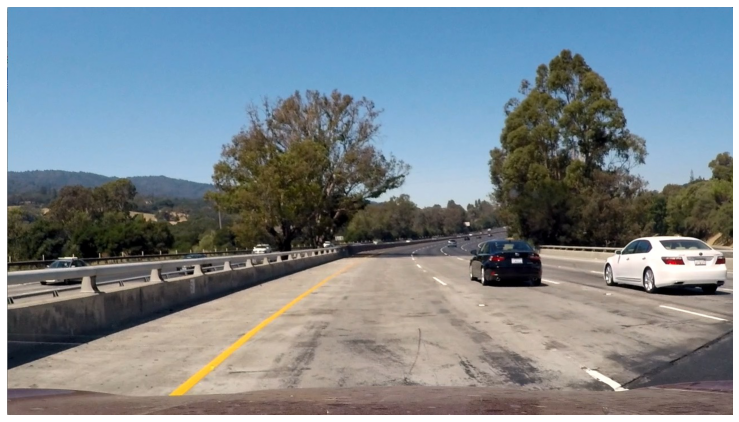

In [16]:
img = mpimg.imread(test1)
plotting(img)

[INFO] YOLO took 0.336063 seconds


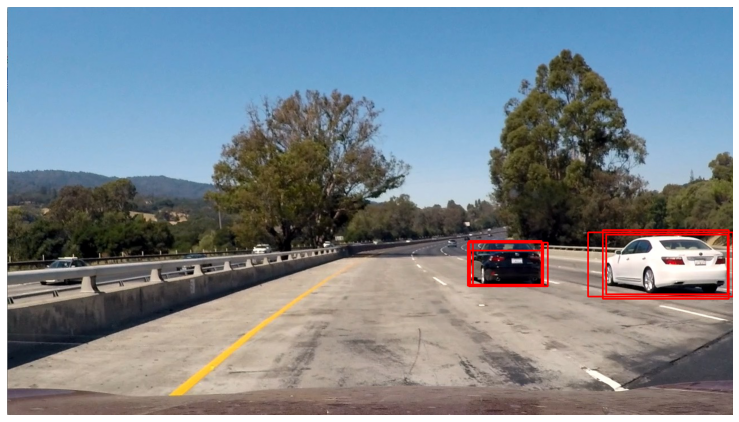

In [17]:
process(img, stage1=True)

[INFO] YOLO took 0.200565 seconds


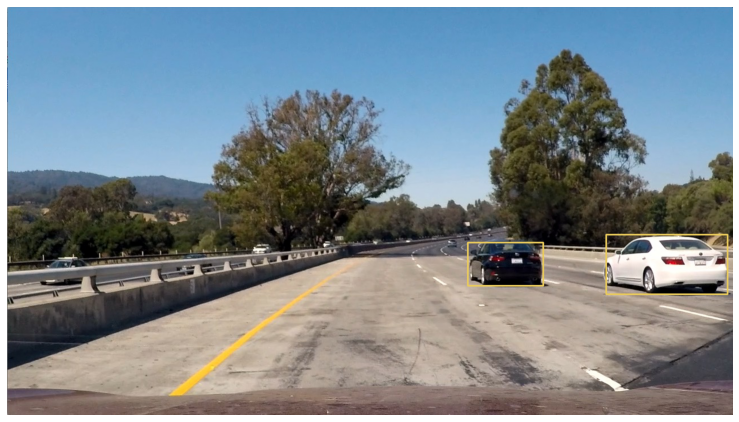

In [18]:
process(img, stage2=True)

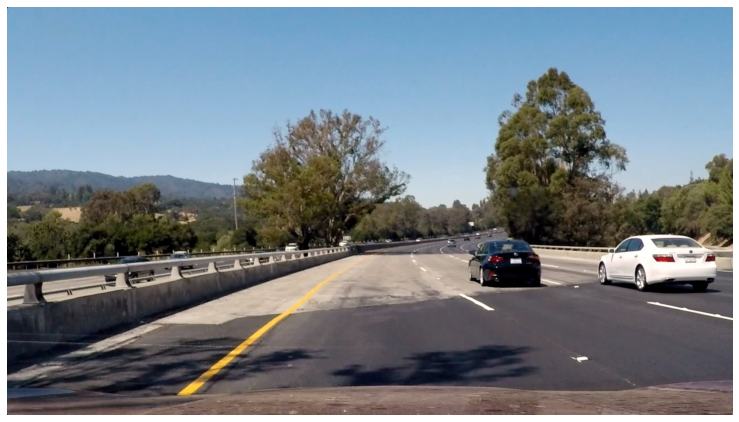

In [19]:
img = mpimg.imread(test4)
plotting(img)

[INFO] YOLO took 0.217129 seconds


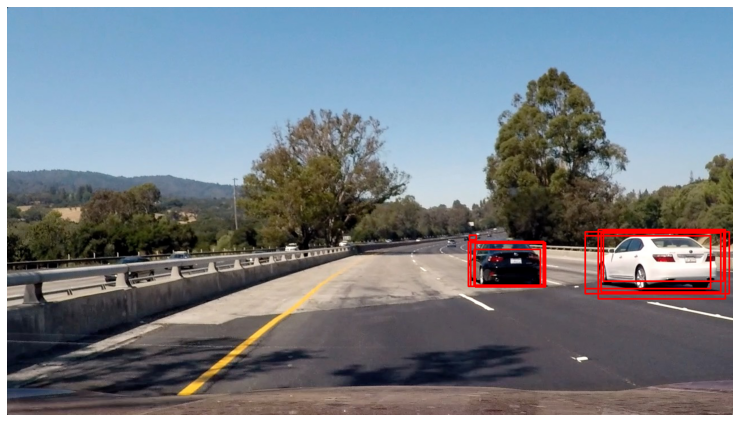

In [20]:
process(img, stage1=True)

[INFO] YOLO took 0.208038 seconds


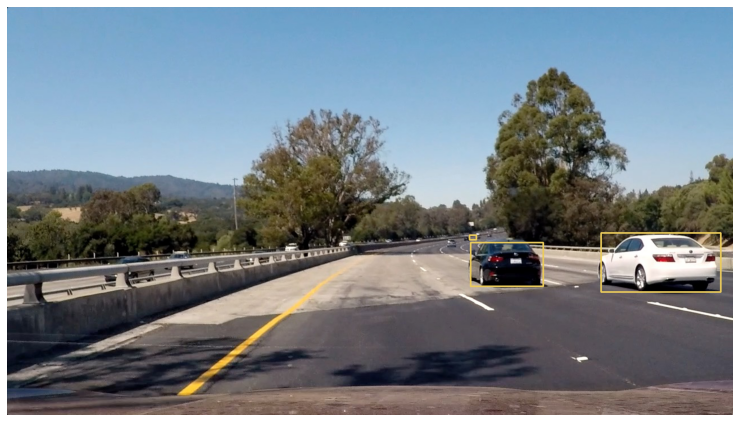

In [21]:
process(img, stage2=True)